In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker #调整刻度
from sklearn.linear_model import LinearRegression
from scipy.optimize import nnls
from scipy.stats import zscore #数据标准化
from scipy.stats import pearsonr #计算相关系数
from sklearn.metrics import r2_score #计算决定系数R^2

# 设置全局字体
plt.rcParams['font.family'] = 'Microsoft YaHei'

In [10]:
import iFinDPy
from iFinDPy import *
from sklearn.preprocessing import StandardScaler

def extract_history_data(start_day, end_day, key_stock):
    THS_iFinDLogin('hfjj278','08c133')
    data1 = THS_HQ('000015.SH,000016.SH,000688.SH,000852.SH,000903.SH,000905.SH,000906.SH,399001.SZ,399005.SZ,399006.SZ,399295.SZ,399296.SZ,399300.SZ,399330.SZ,399673.SZ,399922.SZ,CI005001.CI,CI005002.CI,CI005003.CI,CI005004.CI,CI005005.CI,CI005006.CI,CI005007.CI,CI005008.CI,CI005009.CI,CI005010.CI,CI005011.CI,CI005012.CI,CI005013.CI,CI005014.CI,CI005015.CI,CI005016.CI,CI005017.CI,CI005018.CI,CI005019.CI,CI005020.CI,CI005021.CI,CI005022.CI,CI005023.CI,CI005024.CI,CI005025.CI,CI005026.CI,CI005027.CI,CI005028.CI,CI005029.CI,CI005030.CI','close','',start_day,end_day)
    data2 = THS_HQ(key_stock,'close','',start_day,end_day)
    THS_iFinDLogout()
    data1 = pd.DataFrame(data1.data)
    data1['time'] = pd.to_datetime(data1['time'])
    data2 = pd.DataFrame(data2.data)
    data2['time'] = pd.to_datetime(data2['time'])
    pivot_data1 = data1.pivot_table(index='time', columns='thscode', values='close')
    pivot_data2 = data2.pivot_table(index='time', columns='thscode', values='close')
    #提取时间
    time_period = np.array(pivot_data2.index)
    time_period = np.datetime_as_string(time_period, unit='D')
    #标准化
    scaler = StandardScaler()
    standard_data1 = scaler.fit_transform(pivot_data1)
    standard_data2 = scaler.fit_transform(pivot_data2)
    return standard_data1.round(4),standard_data2.round(4).flatten(),time_period

C:\Users\sharon\anaconda3\Lib\site-packages\iFinDPy.pth


In [5]:
def non_negative_linear_regression(X, y, feature_names, granularity=0):
    
    # 将回归问题转化为非负约束的优化问题
    non_negative_coefficients, _ = nnls(X, y)
    
    # 归一化系数
    sum_coefficients = np.sum(non_negative_coefficients)
    vicoefficients = non_negative_coefficients / sum_coefficients

    # 计算回归函数的预测值
    regression_values = np.dot(X, non_negative_coefficients)

    #从高到低排序
    sorted_vicoefficients = np.array(sorted(zip(feature_names, vicoefficients), key=lambda x: x[1], reverse=True))
    
    if granularity:
        # 提取系数并应用颗粒度处理
        sorted_vicoefficients1 = sorted_vicoefficients[:, 1].astype(float)
        sorted_vicoefficients_granular = np.around(sorted_vicoefficients1 / granularity) * granularity 
        
        # 计算归一化的颗粒度系数(要么人工处理颗粒度，要么总和不为1，这里选择人工处理颗粒度忽略小数)
        adjusted_vicoefficients_granular = sorted_vicoefficients_granular / np.sum(sorted_vicoefficients_granular)
        # 打印结果
        for name, coef in zip(sorted_vicoefficients[:, 0], adjusted_vicoefficients_granular):
            if coef != 0:
                print(name, ':', "{:.2f}%".format(float(coef)*100))
            
        predicted_values_granular = np.dot(X, sorted_vicoefficients_granular)
        """
        以下分别返回按比例投资的预测值数组，按比例投资系数（总和为1，而非回归系数），颗粒化归一系数下的预测值，颗粒化归一系数
        """
        return predicted_values, vicoefficients, predicted_values_granular, sorted_vicoefficients_granular
    
    else:
        # 打印结果
        for name, coef in sorted_vicoefficients:
            coef = float(coef)  # 将系数转换为float类型
            if coef != 0:
                print(name, ':', "{:.2f}%".format(float(coef) * 100))
        """
        不做颗粒度处理则仅返回按比例投资的预测值数组，按比例投资系数（而非实际回归系数）
        """
        return regression_values, non_negative_coefficients

In [79]:
def draw_regression_curve(time_period, regression_values, stock):
    plt.figure(figsize=(20, 7))
    # 绘制回归函数折线图
    plt.plot(time_period, regression_values, color=(0.2,0.4,0.8), label='regression value')
    # 绘制原始样本的折线图
    plt.plot(time_period, stock, color='r', label='origin')
    #设置x轴刻度间隔
    ax = plt.gca()
    ax.xaxis.set_major_locator(ticker.MultipleLocator(10))
    
    plt.xlabel('time')
    plt.ylabel('market value')
    plt.legend()
    plt.show()
    
    R2 = r2_score(regression_values, stock)
    print("R^2 :", R2)

In [80]:
def forecast_within_window(time_period, stock, bunch, coefficients, mod):
    predicted_values = np.dot(bunch, coefficients)
    if mod==1:
        predicted_values1 = predicted_values[:20]
        time_period1 = time_period[:20]
        stock1 = stock[:20]
    if mod==3:
        predicted_values1 = predicted_values[:60]
        time_period1 = time_period[:60]
        stock1 = stock[:60]
    if mod==6:
        predicted_values1 = predicted_values[:120]
        time_period1 = time_period[:120]
        stock1 = stock[:120] 
    R2 = r2_score(predicted_values1, stock1)
    r = pearsonr(predicted_values1, stock1)
    
    plt.figure(figsize=(15, 7))
    # 绘制预测函数折线图
    plt.plot(time_period1, predicted_values1, color='g', label='predicted value')
    # 绘制原始数据的折线图
    plt.plot(time_period1, stock1, color='r', label='origin')
    #设置x轴刻度间隔
    ax = plt.gca()
    ax.xaxis.set_major_locator(ticker.MultipleLocator(10))
    plt.xlabel('time')
    plt.ylabel('market value')
    plt.legend()
    plt.show()
    
    print("R^2:", R2)
    print(r)

In [14]:
bunch_labels = np.array(['红利指数', '上证50', '科创50', '中证1000', '中证100',
                       '中证500', '中证800', '深证成指', '中小100','创业板指', 
                       '创价值','创成长','沪深300','深证100','创业板50',
                        '石油石化指数', '煤炭指数', '有色金属指数', '电力及公用事业指数', '钢铁指数', '基础化工指数',
       '建筑指数', '建材指数', '轻工制造指数', '机械指数', '电力设备及新能源指数', '国防军工指数', '汽车指数',
       '商贸零售指数', '消费者服务指数', '家电指数', '纺织服装指数', '医药指数', '食品饮料指数', '农林牧渔指数',
       '银行指数', '非银行金融指数', '房地产指数', '交通运输指数', '电子指数', '通信指数', '计算机指数', '传媒指数',
       '综合指数', '综合金融指数'])

标为大盘成长

In [13]:
bunch_22l,stock1_22l,time_period_22l = extract_history_data('2022-07-01', '2022-12-31', '399372.SZ')

In [15]:
regression_values1_22l, coefficients1_22l = non_negative_linear_regression(bunch_22l, stock1_22l, bunch_labels)

深证100 : 55.82%
中小100 : 16.01%
创成长 : 13.64%
创业板50 : 5.59%
医药指数 : 5.50%
上证50 : 3.43%


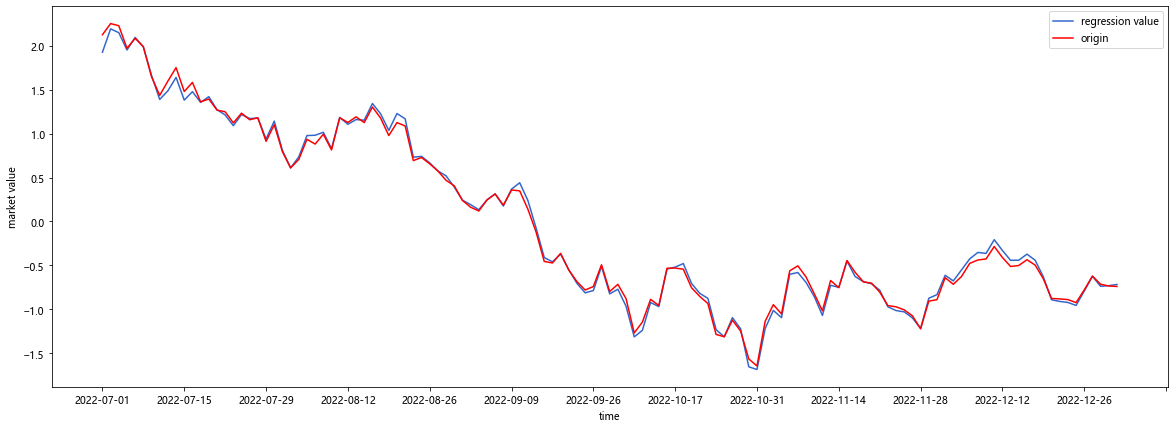

R^2 : 0.9974179403933224


In [18]:
draw_regression_curve(time_period_22l, regression_values1_22l, stock1_22l)

In [19]:
 bunch_23u,stock1_23u,time_period_23u = extract_history_data('2023-01-01', '2023-07-04', '399372.SZ')

22下预测23上

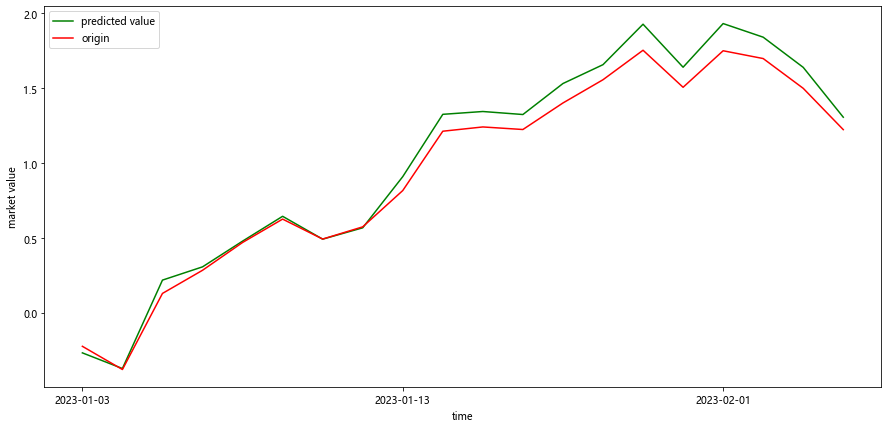

R^2: 0.9788143004976773
PearsonRResult(statistic=0.99901782660251, pvalue=8.048271002490228e-26)


In [27]:
forecast_within_window(time_period_23u, stock1_23u, bunch_23u, coefficients1_22l, 1)

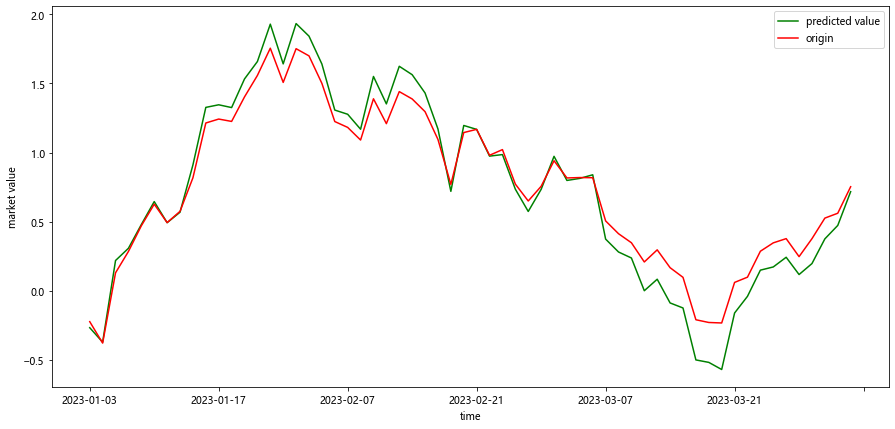

R^2: 0.9580376454822683
PearsonRResult(statistic=0.9938150002288274, pvalue=4.5779409085325625e-57)


In [82]:
forecast_within_window(time_period_23u, stock1_23u, bunch_23u, coefficients1_22l, 3)

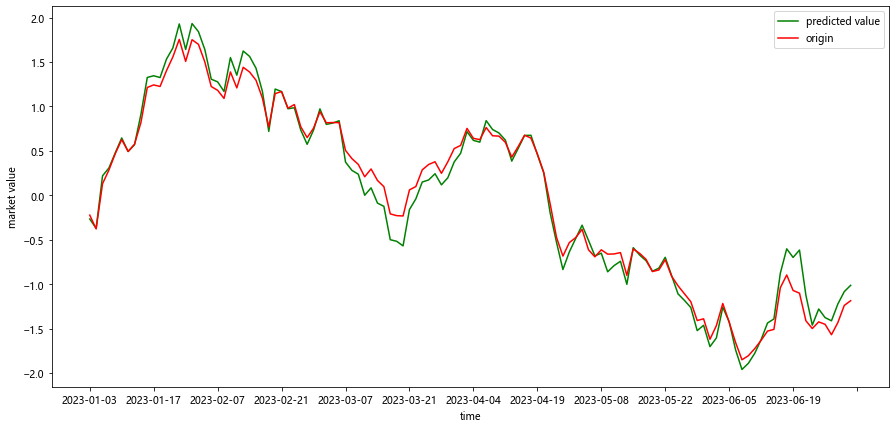

R^2: 0.9831169531487421
PearsonRResult(statistic=0.9916044416832211, pvalue=1.0979597722449192e-106)


In [81]:
forecast_within_window(time_period_23u, stock1_23u, bunch_23u, coefficients1_22l, 6)

22上拟合22下

In [23]:
bunch_22u,stock1_22u,time_period_22u = extract_history_data('2022-01-01', '2022-06-30', '399372.SZ')

In [24]:
regression_values1_22u, coefficients1_22u = non_negative_linear_regression(bunch_22u, stock1_22u, bunch_labels)

创业板50 : 45.26%
食品饮料指数 : 21.13%
创价值 : 11.37%
上证50 : 10.83%
电子指数 : 8.07%
创业板指 : 3.34%


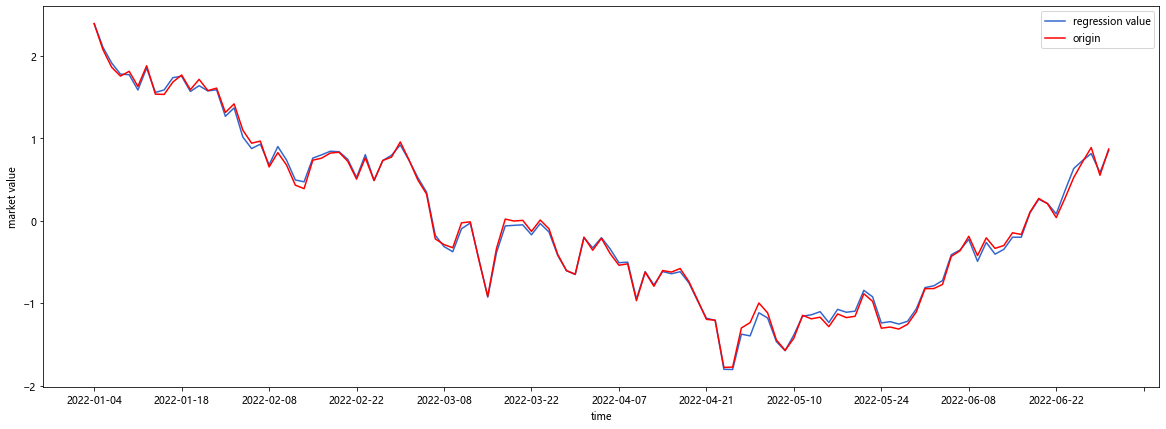

R^2 : 0.9978184622974771


In [25]:
draw_regression_curve(time_period_22u, regression_values1_22u, stock1_22u)

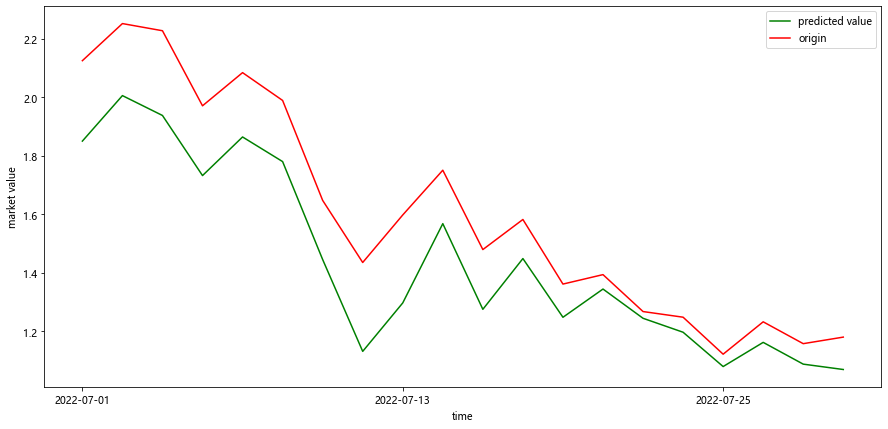

R^2: 0.6145126439699318
PearsonRResult(statistic=0.980221829709967, pvalue=4.0942006392488793e-14)


In [29]:
forecast_within_window(time_period_22l, stock1_22l, bunch_22l, coefficients1_22u, 1)

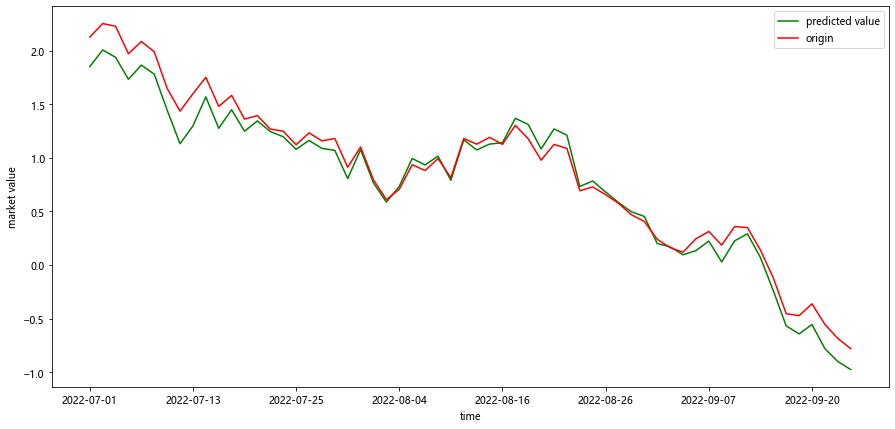

R^2: 0.963573102415527
PearsonRResult(statistic=0.9877262921838571, pvalue=1.8037455689208863e-48)


In [30]:
forecast_within_window(time_period_22l, stock1_22l, bunch_22l, coefficients1_22u, 3)

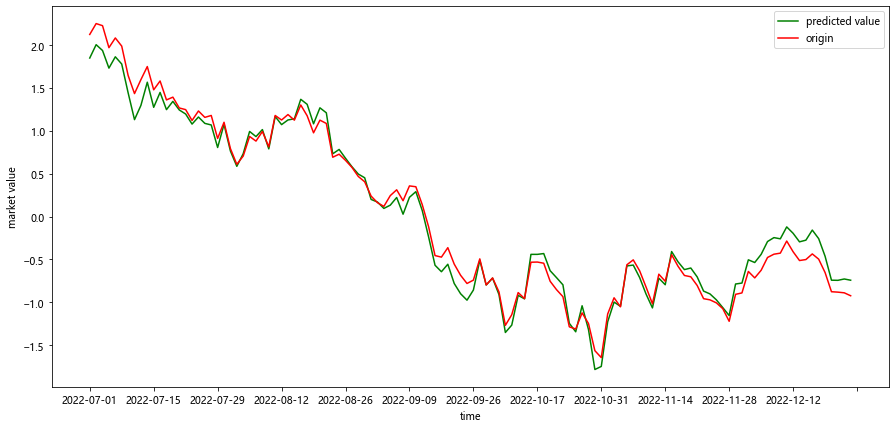

R^2: 0.9814384871489216
PearsonRResult(statistic=0.9923175834580081, pvalue=5.955260235156921e-109)


In [83]:
forecast_within_window(time_period_22l, stock1_22l, bunch_22l, coefficients1_22u, 6)

21下预测22上

In [32]:
bunch_21l,stock1_21l,time_period_21l = extract_history_data('2021-07-01', '2021-12-31', '399372.SZ')

In [33]:
regression_values1_21l, coefficients1_21l = non_negative_linear_regression(bunch_21l, stock1_21l, bunch_labels)

食品饮料指数 : 30.77%
创业板50 : 16.21%
上证50 : 12.09%
消费者服务指数 : 9.29%
创价值 : 7.56%
医药指数 : 7.33%
创业板指 : 5.02%
石油石化指数 : 3.88%
创成长 : 3.84%
科创50 : 2.34%
电子指数 : 1.68%


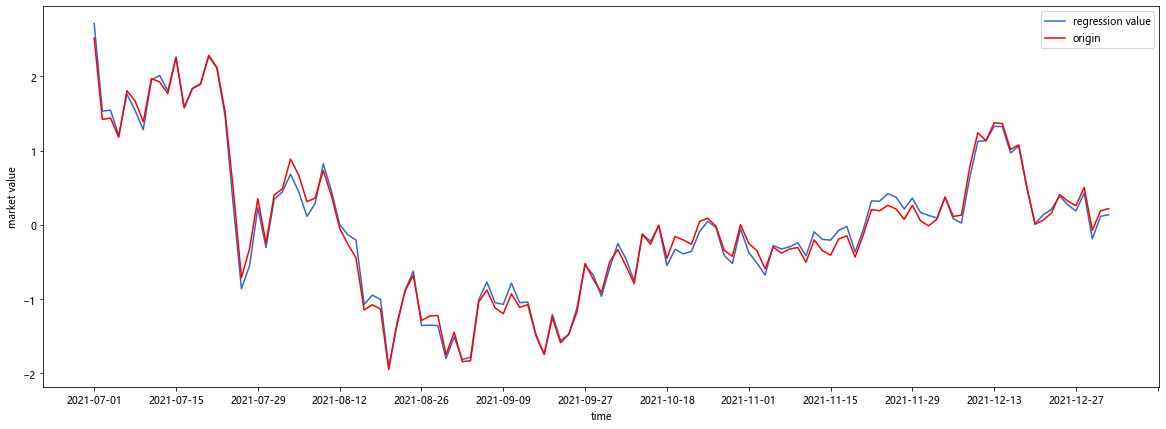

R^2 : 0.9902564214846147


In [37]:
draw_regression_curve(time_period_21l, regression_values1_21l, stock1_21l)

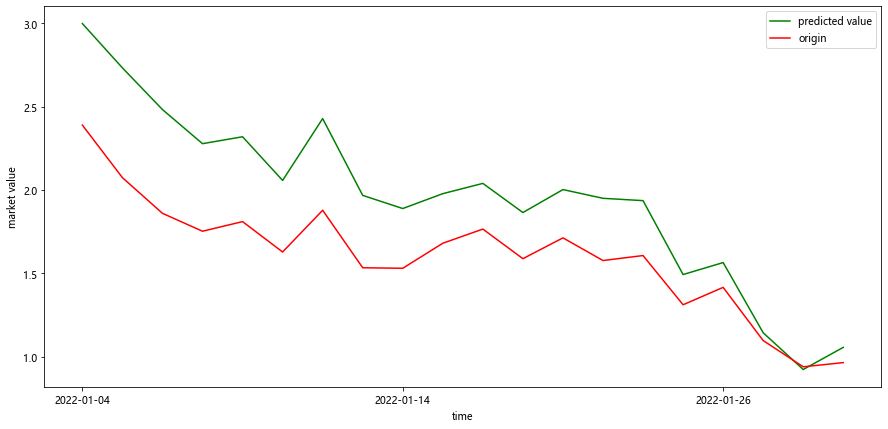

R^2: 0.4091993807817327
PearsonRResult(statistic=0.985580559486372, pvalue=2.429227843658811e-15)


In [34]:
forecast_within_window(time_period_22u, stock1_22u, bunch_22u, coefficients1_21l, 1)

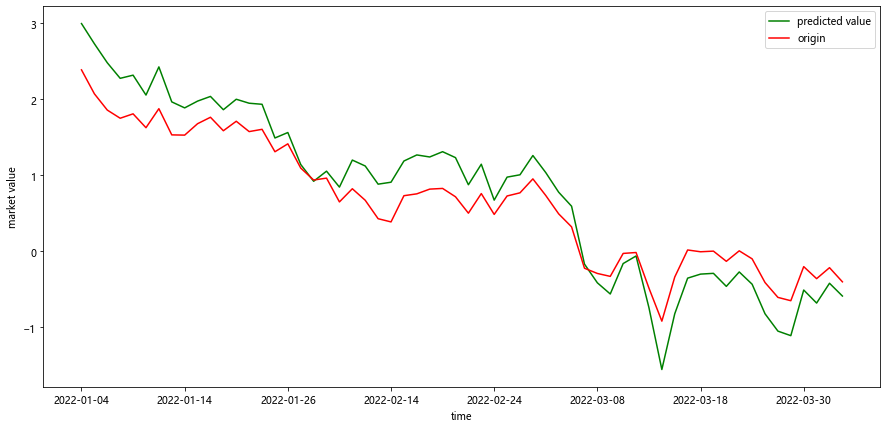

R^2: 0.8908487785712603
PearsonRResult(statistic=0.9845061921864977, pvalue=1.483933659765992e-45)


In [35]:
forecast_within_window(time_period_22u, stock1_22u, bunch_22u, coefficients1_21l, 3)

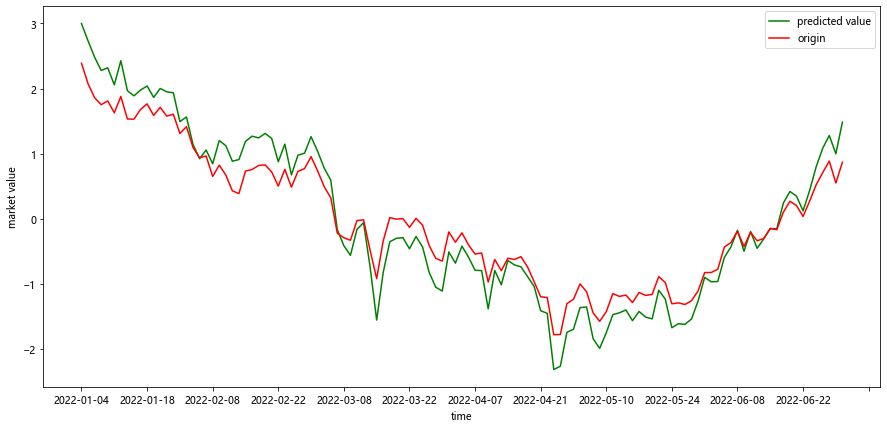

R^2: 0.9353849224132654
PearsonRResult(statistic=0.9915644202525595, pvalue=6.753783321050611e-104)


In [84]:
forecast_within_window(time_period_22u, stock1_22u, bunch_22u, coefficients1_21l, 6)

标为中证全指

In [51]:
_,stock2_23u,_ = extract_history_data('2023-01-01', '2023-07-04', '000985.CSI')
_,stock2_22l,_ = extract_history_data('2022-07-01', '2022-12-31', '000985.CSI')
_,stock2_22u,_ = extract_history_data('2022-01-01', '2022-06-30', '000985.CSI')
_,stock2_21l,_ = extract_history_data('2021-07-01', '2021-12-31', '000985.CSI')

22下预测23上

In [40]:
regression_values2_22l, coefficients2_22l = non_negative_linear_regression(bunch_22l, stock2_22l, bunch_labels)

电力设备及新能源指数 : 8.58%
电子指数 : 7.29%
上证50 : 7.28%
基础化工指数 : 6.07%
沪深300 : 5.38%
食品饮料指数 : 5.32%
医药指数 : 5.21%
机械指数 : 4.52%
汽车指数 : 4.14%
中证1000 : 4.06%
深证成指 : 3.99%
中证500 : 3.87%
计算机指数 : 3.09%
有色金属指数 : 2.83%
银行指数 : 2.41%
深证100 : 2.24%
中证100 : 2.16%
建材指数 : 2.08%
建筑指数 : 1.74%
红利指数 : 1.62%
农林牧渔指数 : 1.55%
电力及公用事业指数 : 1.49%
非银行金融指数 : 1.44%
消费者服务指数 : 1.32%
纺织服装指数 : 1.09%
中小100 : 1.06%
通信指数 : 1.03%
商贸零售指数 : 0.99%
国防军工指数 : 0.93%
传媒指数 : 0.90%
综合指数 : 0.86%
家电指数 : 0.75%
钢铁指数 : 0.72%
房地产指数 : 0.59%
交通运输指数 : 0.45%
综合金融指数 : 0.35%
石油石化指数 : 0.30%
煤炭指数 : 0.29%


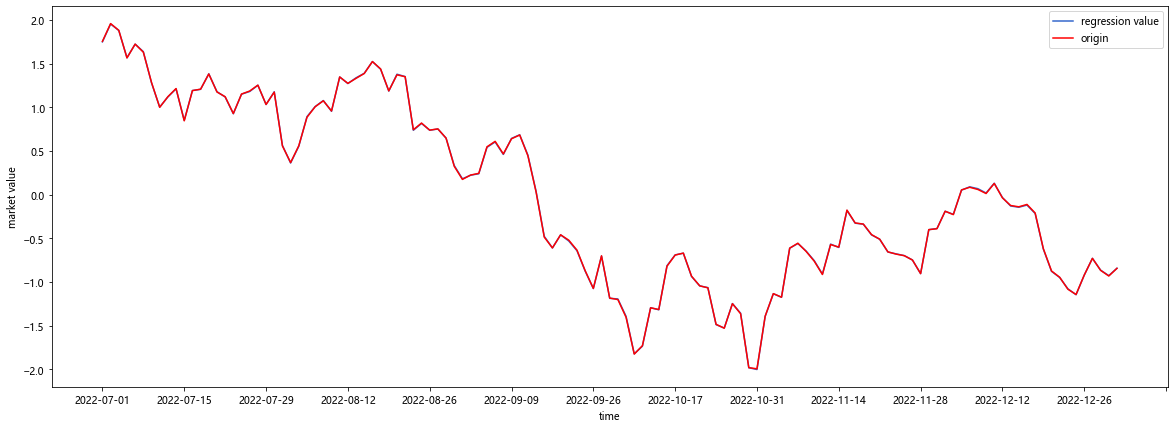

R^2 : 0.9999814922212288


In [41]:
draw_regression_curve(time_period_22l, regression_values2_22l, stock2_22l)

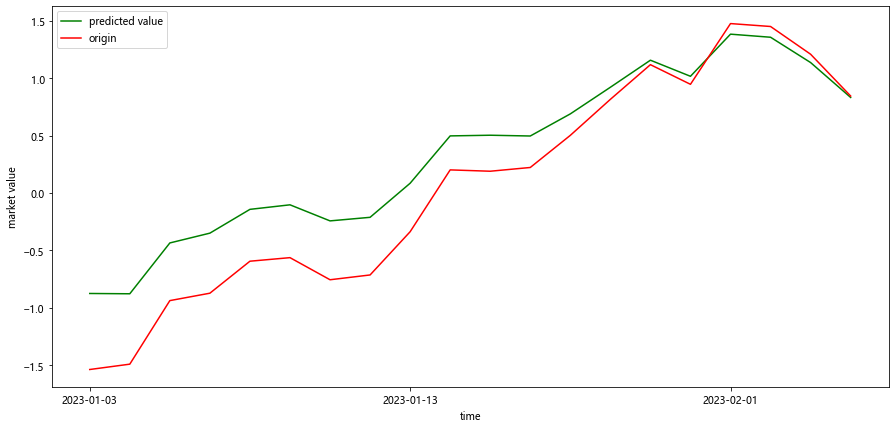

R^2: 0.7167015264280704
PearsonRResult(statistic=0.9983932246810191, pvalue=6.739511037090235e-24)


In [42]:
forecast_within_window(time_period_23u, stock2_23u, bunch_23u, coefficients2_22l, 1)

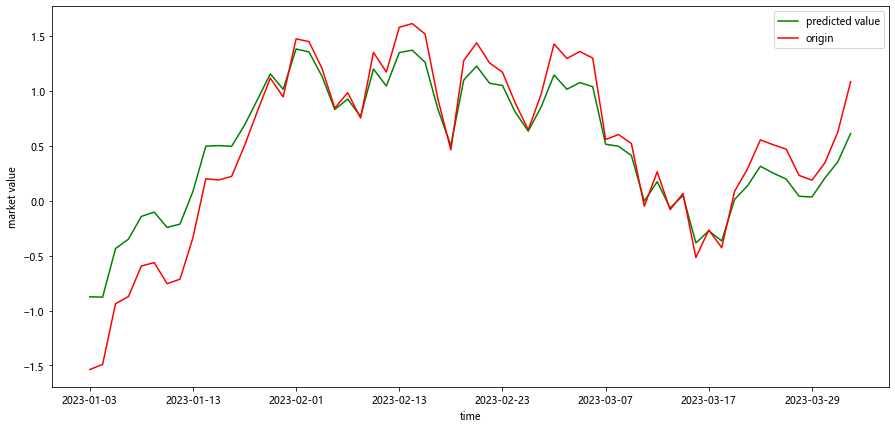

R^2: 0.8009441983882627
PearsonRResult(statistic=0.9656621655328909, pvalue=1.2083096117868267e-35)


In [43]:
forecast_within_window(time_period_23u, stock2_23u, bunch_23u, coefficients2_22l, 3)

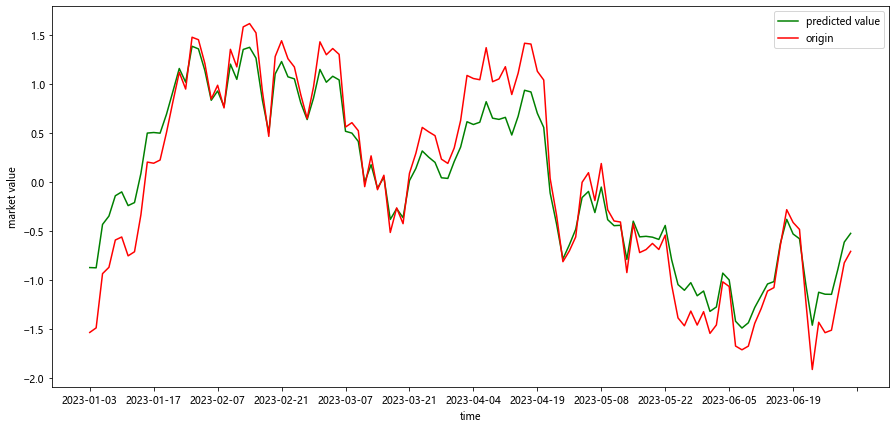

R^2: 0.8910312462948844
PearsonRResult(statistic=0.9779803664654014, pvalue=3.7798616148984806e-82)


In [85]:
forecast_within_window(time_period_23u, stock2_23u, bunch_23u, coefficients2_22l, 6)

22上预测22下

In [45]:
regression_values2_22u, coefficients2_22u = non_negative_linear_regression(bunch_22u, stock2_22u, bunch_labels)

中证800 : 28.56%
中证1000 : 23.10%
电子指数 : 5.29%
计算机指数 : 4.56%
电力设备及新能源指数 : 4.29%
沪深300 : 3.82%
医药指数 : 3.18%
机械指数 : 2.82%
汽车指数 : 2.28%
食品饮料指数 : 2.10%
基础化工指数 : 1.95%
综合金融指数 : 1.91%
非银行金融指数 : 1.68%
上证50 : 1.54%
商贸零售指数 : 1.52%
银行指数 : 1.49%
中证100 : 1.06%
钢铁指数 : 0.90%
纺织服装指数 : 0.82%
轻工制造指数 : 0.77%
交通运输指数 : 0.75%
红利指数 : 0.74%
有色金属指数 : 0.72%
消费者服务指数 : 0.66%
农林牧渔指数 : 0.62%
国防军工指数 : 0.59%
传媒指数 : 0.53%
建筑指数 : 0.49%
家电指数 : 0.49%
房地产指数 : 0.32%
综合指数 : 0.24%
通信指数 : 0.14%
石油石化指数 : 0.03%
电力及公用事业指数 : 0.03%


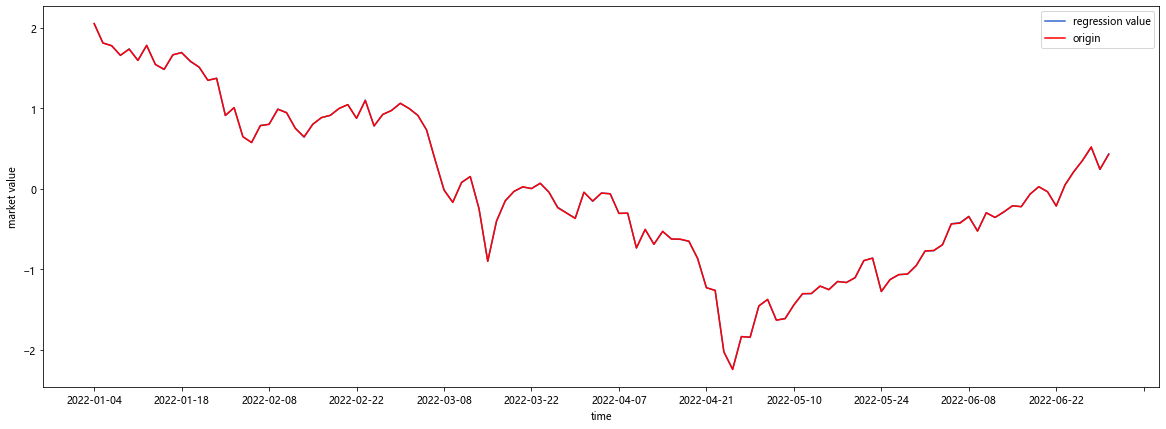

R^2 : 0.9999931368059866


In [46]:
draw_regression_curve(time_period_22u, regression_values2_22u, stock2_22u)

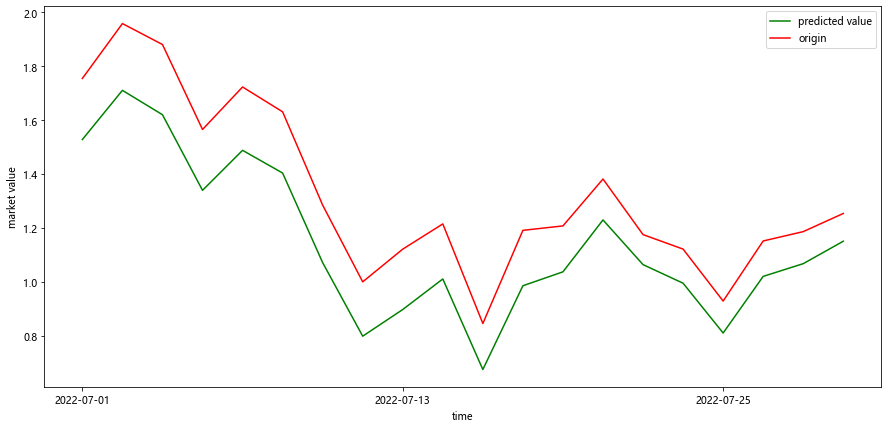

R^2: 0.5319822529799965
PearsonRResult(statistic=0.9909933956867106, pvalue=3.58497969347337e-17)


In [47]:
forecast_within_window(time_period_22l, stock2_22l, bunch_22l, coefficients2_22u, 1)

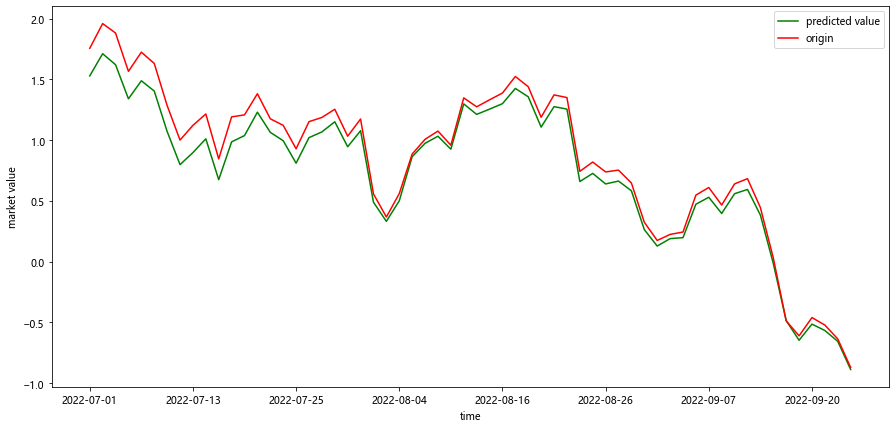

R^2: 0.9580283411538848
PearsonRResult(statistic=0.9966731199664259, pvalue=7.374495395467539e-65)


In [48]:
forecast_within_window(time_period_22l, stock2_22l, bunch_22l, coefficients2_22u, 3)

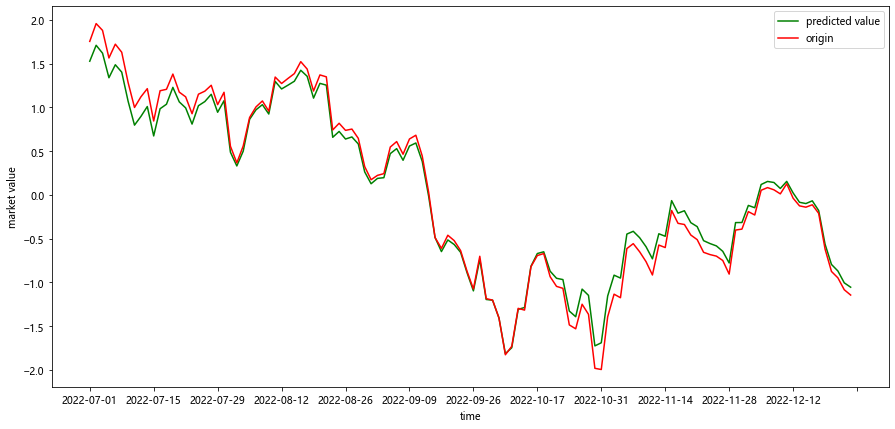

R^2: 0.9818490293359687
PearsonRResult(statistic=0.9970388226364412, pvalue=2.5441934953690696e-133)


In [86]:
forecast_within_window(time_period_22l, stock2_22l, bunch_22l, coefficients2_22u, 6)

21下预测22上

In [52]:
regression_values2_21l, coefficients2_21l = non_negative_linear_regression(bunch_21l, stock2_21l, bunch_labels)

电力设备及新能源指数 : 9.28%
医药指数 : 9.03%
中证100 : 8.22%
中证1000 : 6.58%
食品饮料指数 : 6.05%
电子指数 : 5.95%
基础化工指数 : 5.12%
有色金属指数 : 4.63%
中证500 : 3.52%
机械指数 : 3.42%
建筑指数 : 2.97%
电力及公用事业指数 : 2.81%
银行指数 : 2.49%
汽车指数 : 2.48%
国防军工指数 : 2.24%
深证成指 : 2.21%
煤炭指数 : 2.20%
计算机指数 : 2.16%
传媒指数 : 2.16%
非银行金融指数 : 2.11%
交通运输指数 : 1.81%
石油石化指数 : 1.60%
农林牧渔指数 : 1.42%
钢铁指数 : 1.30%
沪深300 : 1.19%
建材指数 : 1.12%
轻工制造指数 : 1.12%
创价值 : 0.93%
房地产指数 : 0.72%
家电指数 : 0.64%
综合指数 : 0.52%
纺织服装指数 : 0.47%
创成长 : 0.41%
消费者服务指数 : 0.35%
商贸零售指数 : 0.31%
综合金融指数 : 0.25%
通信指数 : 0.23%


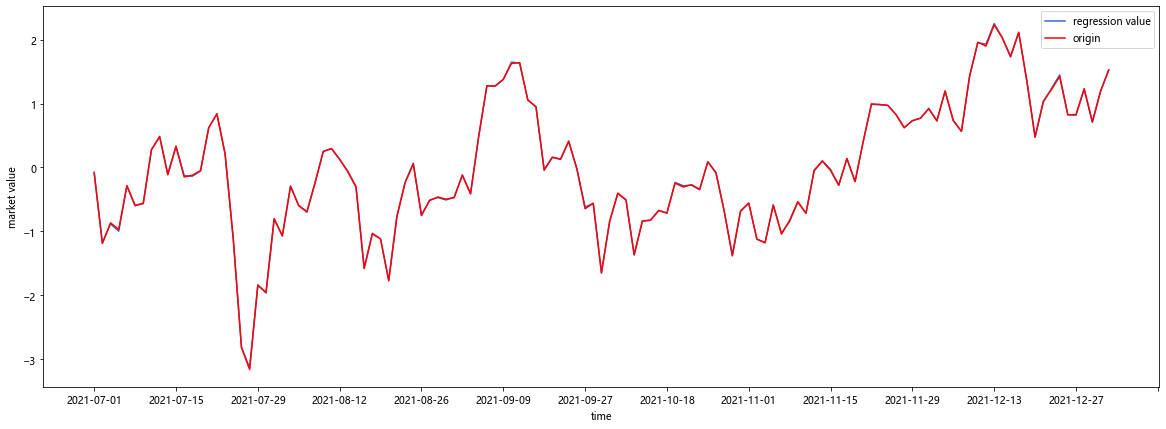

R^2 : 0.9998983123213933


In [53]:
draw_regression_curve(time_period_21l, regression_values2_21l, stock2_21l)

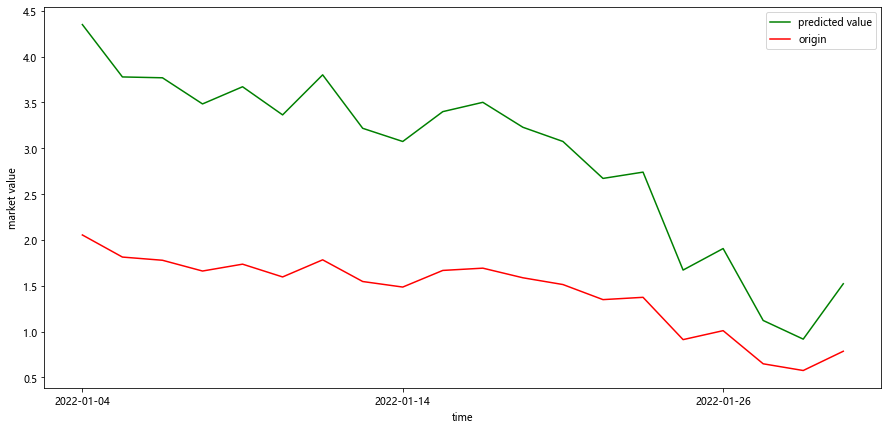

R^2: -1.7700441907917606
PearsonRResult(statistic=0.9987672255157877, pvalue=6.216842062652801e-25)


In [54]:
forecast_within_window(time_period_22u, stock2_22u, bunch_22u, coefficients2_21l, 1)

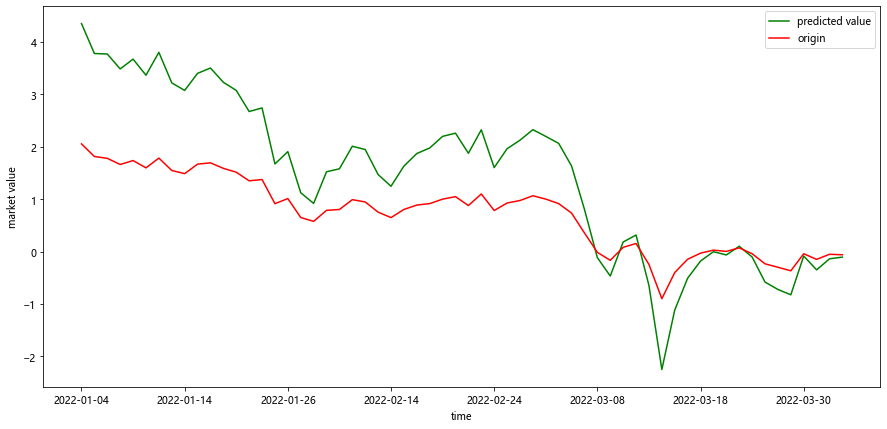

R^2: 0.4771809286619386
PearsonRResult(statistic=0.9979648665320738, pvalue=4.8467537843451534e-71)


In [55]:
forecast_within_window(time_period_22u, stock2_22u, bunch_22u, coefficients2_21l, 3)

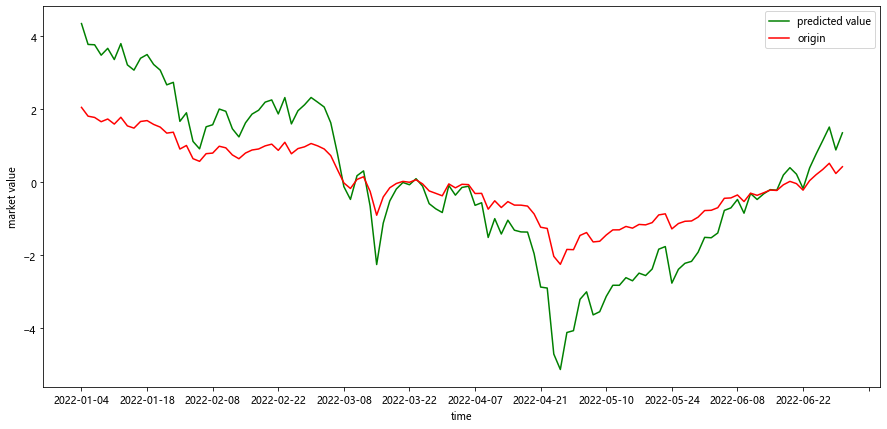

R^2: 0.7133622883687921
PearsonRResult(statistic=0.9968194212094186, pvalue=3.4323493090937204e-128)


In [87]:
forecast_within_window(time_period_22u, stock2_22u, bunch_22u, coefficients2_21l, 6)

标为上证综指

In [58]:
_,stock3_23u,_ = extract_history_data('2023-01-01', '2023-07-04', '000001.SH')
_,stock3_22l,_ = extract_history_data('2022-07-01', '2022-12-31', '000001.SH')
_,stock3_22u,_ = extract_history_data('2022-01-01', '2022-06-30', '000001.SH')
_,stock3_21l,_ = extract_history_data('2021-07-01', '2021-12-31', '000001.SH')

22下预测23上

In [60]:
regression_values3_22l, coefficients3_22l = non_negative_linear_regression(bunch_22l, stock3_22l, bunch_labels)

上证50 : 25.87%
科创50 : 11.16%
中证500 : 10.03%
红利指数 : 7.51%
创价值 : 5.62%
汽车指数 : 5.49%
银行指数 : 4.48%
建筑指数 : 4.40%
石油石化指数 : 4.22%
消费者服务指数 : 3.17%
电力及公用事业指数 : 3.10%
非银行金融指数 : 3.01%
基础化工指数 : 2.85%
纺织服装指数 : 2.78%
电子指数 : 1.36%
国防军工指数 : 1.19%
交通运输指数 : 1.19%
商贸零售指数 : 1.14%
农林牧渔指数 : 0.51%
通信指数 : 0.46%
创成长 : 0.43%
钢铁指数 : 0.03%


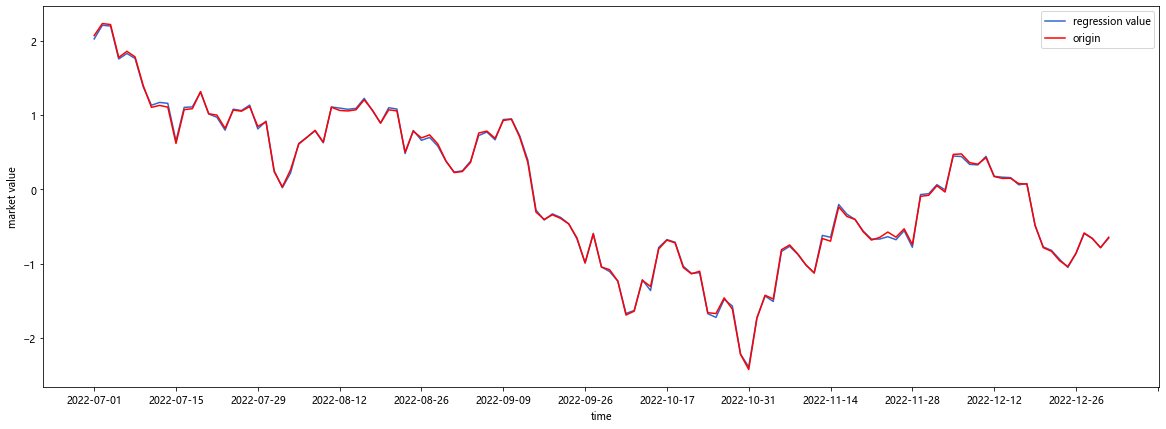

R^2 : 0.9994736428648442


In [61]:
draw_regression_curve(time_period_22l, regression_values3_22l, stock3_22l)

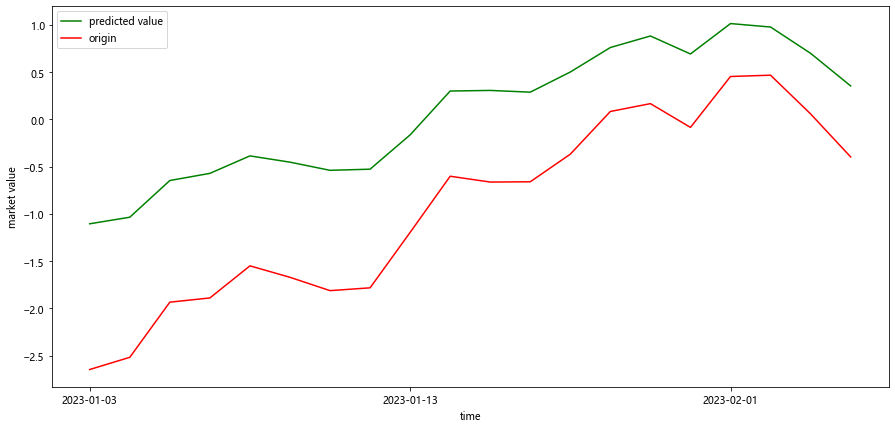

R^2: -1.4416645793253782
PearsonRResult(statistic=0.9984200957104253, pvalue=5.790966652197364e-24)


In [62]:
forecast_within_window(time_period_23u, stock3_23u, bunch_23u, coefficients3_22l, 1)

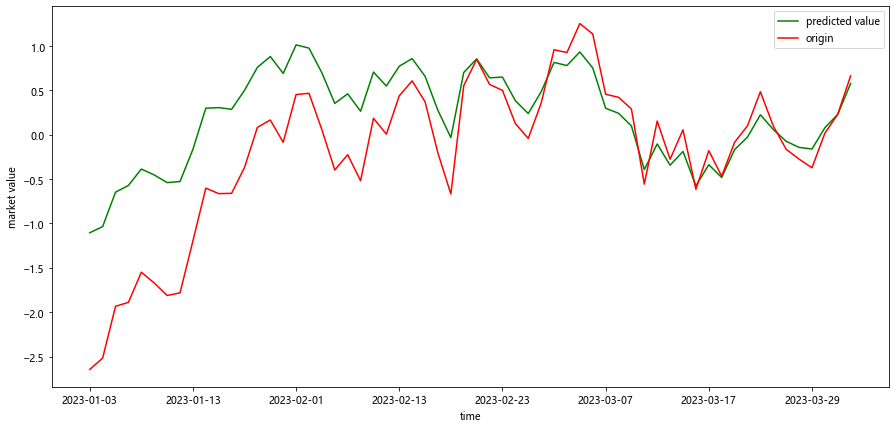

R^2: -0.5307312849380292
PearsonRResult(statistic=0.8258218785971733, pvalue=4.669406408791233e-16)


In [63]:
forecast_within_window(time_period_23u, stock3_23u, bunch_23u, coefficients3_22l, 3)

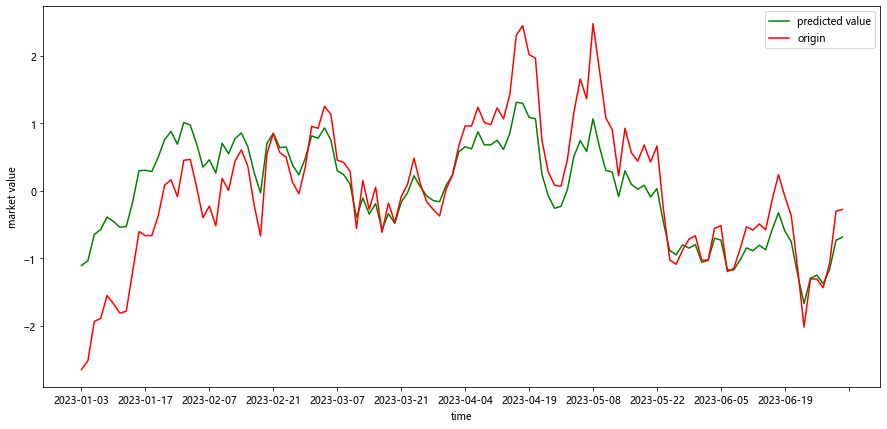

R^2: 0.298903177459098
PearsonRResult(statistic=0.8187316703421527, pvalue=3.29244187230394e-30)


In [88]:
forecast_within_window(time_period_23u, stock3_23u, bunch_23u, coefficients3_22l, 6)

22上预测22下

In [65]:
regression_values3_22u, coefficients3_22u = non_negative_linear_regression(bunch_22u, stock3_22u, bunch_labels)

中证500 : 22.75%
上证50 : 11.95%
电力及公用事业指数 : 7.67%
汽车指数 : 5.36%
食品饮料指数 : 5.34%
非银行金融指数 : 4.75%
银行指数 : 4.58%
电力设备及新能源指数 : 4.42%
煤炭指数 : 4.25%
科创50 : 4.23%
家电指数 : 3.79%
基础化工指数 : 3.04%
钢铁指数 : 2.69%
医药指数 : 2.48%
交通运输指数 : 2.19%
国防军工指数 : 1.69%
石油石化指数 : 1.67%
建筑指数 : 1.49%
房地产指数 : 1.45%
有色金属指数 : 1.37%
机械指数 : 0.88%
纺织服装指数 : 0.84%
农林牧渔指数 : 0.78%
消费者服务指数 : 0.34%


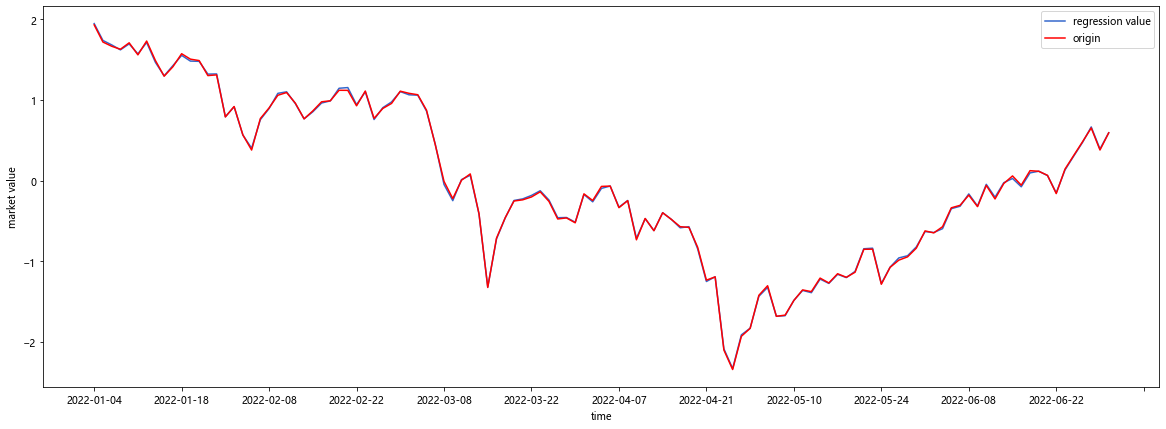

R^2 : 0.9997998946891669


In [66]:
draw_regression_curve(time_period_22u, regression_values3_22u, stock3_22u)

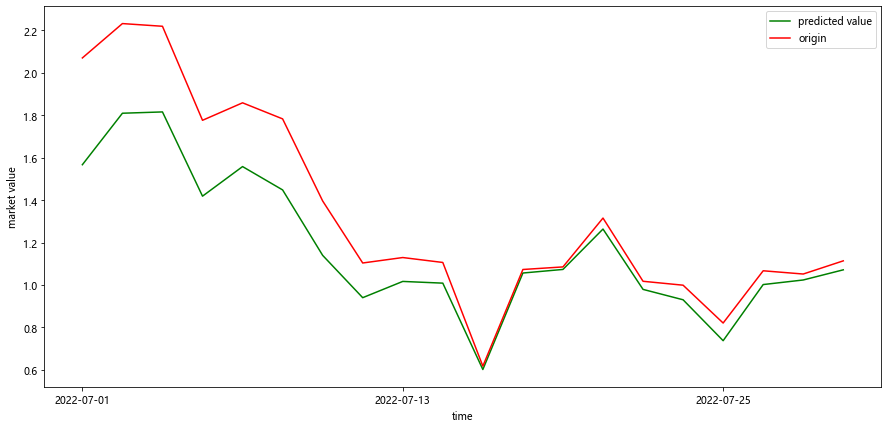

R^2: 0.4866075084331172
PearsonRResult(statistic=0.9833444935076412, pvalue=8.819304027990159e-15)


In [67]:
forecast_within_window(time_period_22l, stock3_22l, bunch_22l, coefficients3_22u, 1)

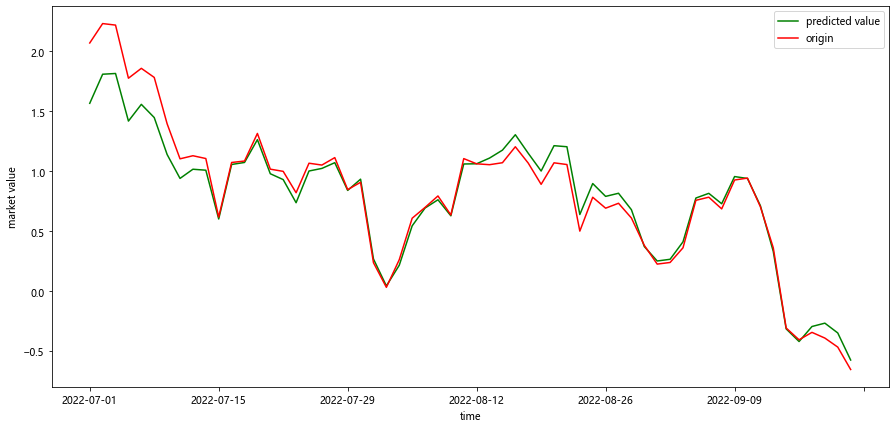

R^2: 0.9250182435728881
PearsonRResult(statistic=0.9800577409542862, pvalue=2.1082373402415102e-42)


In [90]:
forecast_within_window(time_period_22l, stock3_22l, bunch_22l, coefficients3_22u, 3)

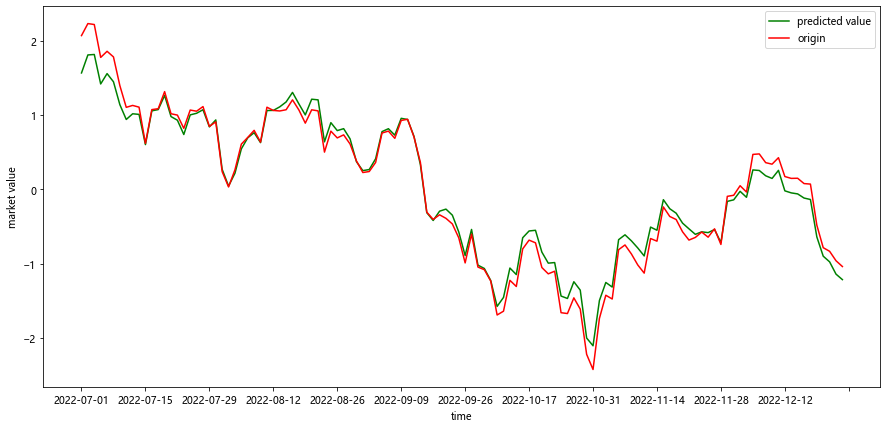

R^2: 0.9723345858355524
PearsonRResult(statistic=0.9917515064873871, pvalue=3.886810359472709e-107)


In [91]:
forecast_within_window(time_period_22l, stock3_22l, bunch_22l, coefficients3_22u, 6)

21下预测22上

In [71]:
regression_values3_21l, coefficients3_21l = non_negative_linear_regression(bunch_21l, stock3_21l, bunch_labels)

上证50 : 16.00%
红利指数 : 14.05%
电力及公用事业指数 : 10.19%
电力设备及新能源指数 : 7.92%
交通运输指数 : 6.49%
机械指数 : 6.35%
食品饮料指数 : 5.67%
中证1000 : 4.26%
石油石化指数 : 3.63%
医药指数 : 3.62%
银行指数 : 3.25%
电子指数 : 2.79%
建筑指数 : 2.62%
汽车指数 : 2.57%
基础化工指数 : 2.05%
钢铁指数 : 1.98%
有色金属指数 : 1.57%
非银行金融指数 : 1.50%
煤炭指数 : 1.41%
国防军工指数 : 1.15%
综合金融指数 : 0.88%
消费者服务指数 : 0.04%


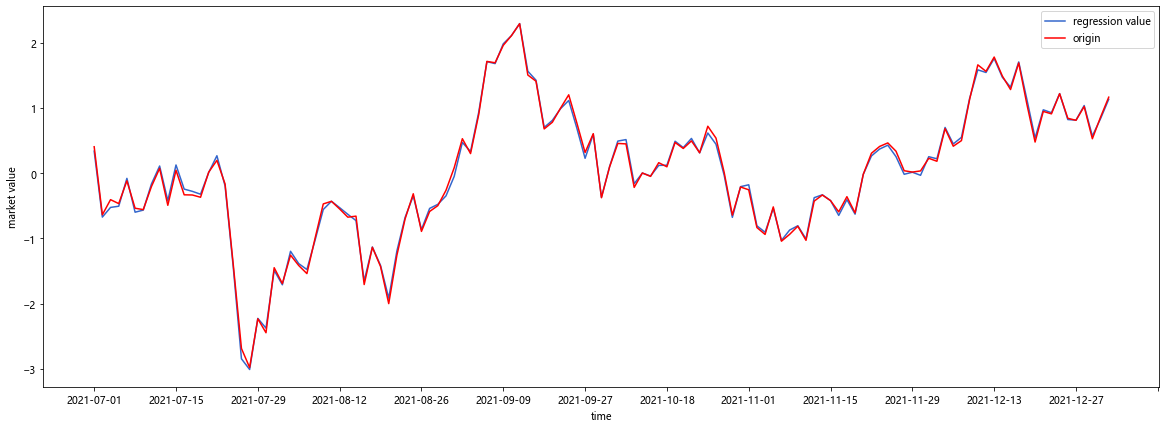

R^2 : 0.9975819382827422


In [72]:
draw_regression_curve(time_period_21l, regression_values3_21l, stock3_21l)

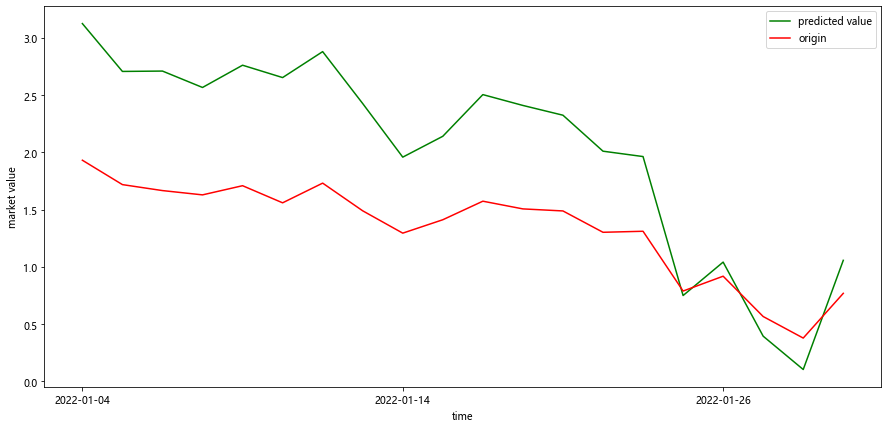

R^2: 0.08733993001848128
PearsonRResult(statistic=0.9946598565498382, pvalue=3.2897497966966435e-19)


In [73]:
forecast_within_window(time_period_22u, stock3_22u, bunch_22u, coefficients3_21l, 1)

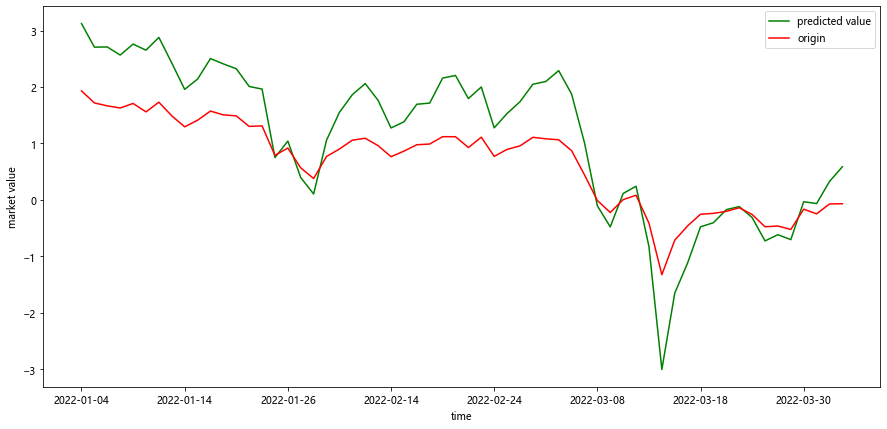

R^2: 0.6875329823168942
PearsonRResult(statistic=0.9780116053720719, pvalue=3.4828120706231565e-41)


In [75]:
forecast_within_window(time_period_22u, stock3_22u, bunch_22u, coefficients3_21l, 3)

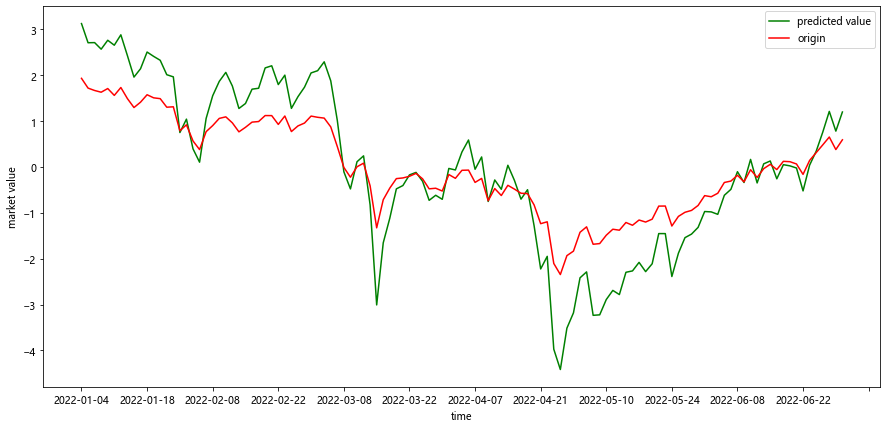

R^2: 0.8034673361129592
PearsonRResult(statistic=0.9870534963445127, pvalue=2.9650137439370473e-93)


In [92]:
forecast_within_window(time_period_22u, stock3_22u, bunch_22u, coefficients3_21l, 6)